<a href="https://colab.research.google.com/github/flavio055063/desafio-ninja/blob/main/desafio_ninja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## - Nome: Flávio Augusto Aló Torres
## - email: flaviowet@gmail.com

- Conectando ao Google BigQuery com Python: https://hex.tech/blog/connecting-bigquery-python/

- Você precisará criar uma conta no Google Cloud.

  Lhe pedirão um cartão de crédito pela avaliação, porém nada será cobrado.

In [ ]:
!pip install google-cloud-bigquery

- Você precisará criar uma conta de serviço para realizar as consultas com Python.

  https://cloud.google.com/iam/docs/service-accounts-create?hl=pt-br#creating

  Após criá-la, crie uma chave, baixe-a e carregue-a neste COLAB.

  Você também precisará adicionar a seguinte permissão à conta de serviço, na aba "Gerenciar Recursos":
  - Usuário de Jobs do BigQuery


In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

In [ ]:
credentials = service_account.Credentials.from_service_account_file('credentials.json')
project_id = 'projeto-estagio-ninja' # substitua pelo id do seu projeto
client = bigquery.Client(credentials= credentials,project=project_id)

### Definindo função para conversão e maior legibilidade de valor em moeda no gráfico

In [101]:
# Formata o eixo y em dinheiro (formato de moeda)
def format_currency(value, tick_number):
    formatted_value = 'R$ {:,.0f}'.format(value).replace(',', '.')  # Adiciona ponto a cada 3 dígitos para maior legibilidade
    return formatted_value

### Como estão as vendas nos últimos anos?
### Consulta SQL para ver o valor de vendas durante os anos. Os valores podem ficar **distorcidos** porque pedidos cancelados, em processamento, retornados e enviados foram considerados nessa consulta. Para valores das vendas que deram certo, olhe o próximo gráfico.

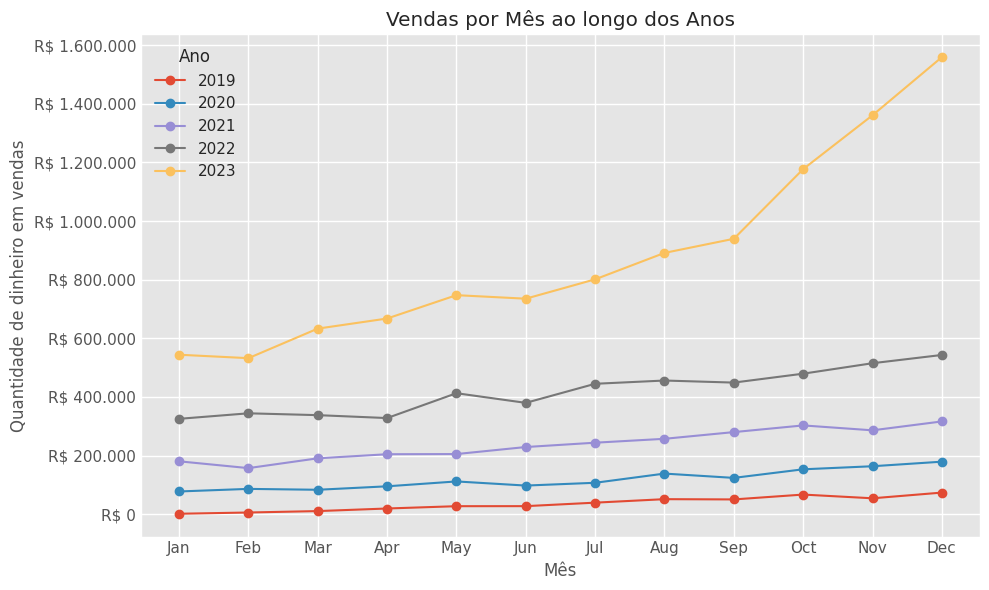

In [144]:
query = client.query(
    """
    SELECT EXTRACT(MONTH FROM o.created_at) AS month,
      EXTRACT(YEAR FROM o.created_at) AS year,
      SUM(oi.sale_price*o.num_of_item) AS total_sales
      FROM `bigquery-public-data.thelook_ecommerce.orders` AS o
      JOIN `bigquery-public-data.thelook_ecommerce.order_items` AS oi ON o.order_id = oi.order_id
      GROUP BY year, month
      ORDER BY year, month
    """)

#guardando em dataframe do pandas
df = query.to_dataframe()

# Agrupa os dados por ano e mês, somando as vendas
pivot_df = df.pivot(index='month', columns='year', values='total_sales')

# Cria o gráfico de linha para cada ano
plt.figure(figsize=(10, 6))
for year in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[year], marker='o', label=str(year))

# Configurações do gráfico
plt.xlabel('Mês')
plt.ylabel('Quantidade de dinheiro em vendas')
plt.title('Vendas por Mês ao longo dos Anos')
plt.legend(title='Ano')

# Ajusta os rótulos do eixo x para exibir os nomes dos meses
plt.xticks(ticks=range(1, 13), labels=order_months)  # Defina os rótulos de 1 a 12 com os nomes dos meses

formatter = ticker.FuncFormatter(format_currency)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


### Gerando gráfico com as porcentagens de **status de todas as vendas feitas até o momento**

Note a porcentagem de pedidos cancelados ou retornados. Achei a taxa de retorno e cancelamento um pouco alta (25% somando os dois), seria interessante investigar motivos ou perfis específicos relacionados. Muitas vezes retornar produtos pode causar prejuízo (com frete por exemplo)

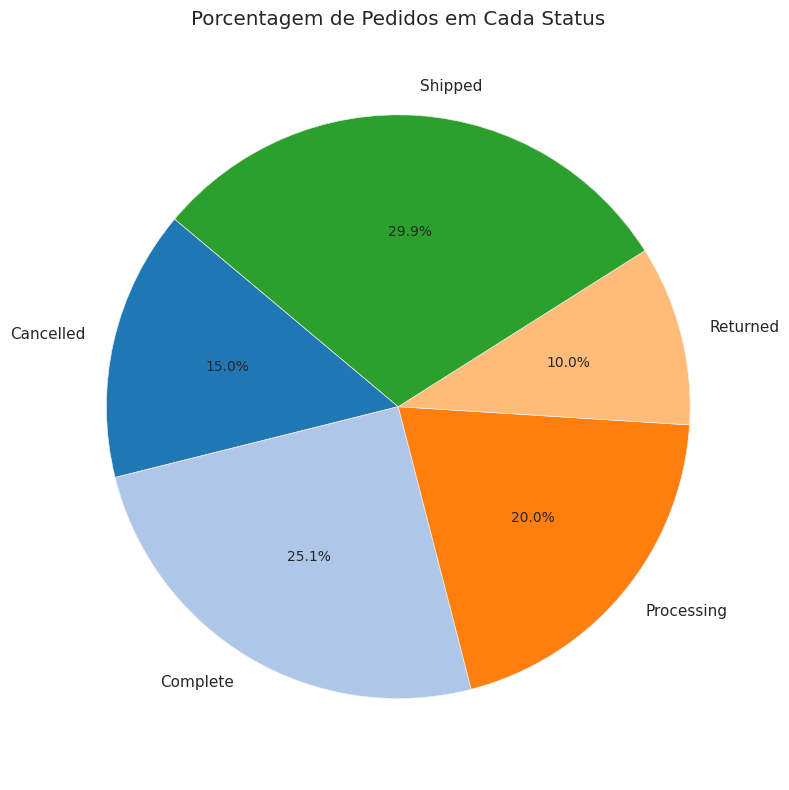

In [136]:
query3 = client.query(
    """
    SELECT
      o.status,
      COUNT(*) AS status_count,
    ROUND((COUNT(*) * 100.0) / (SELECT COUNT(*) FROM `bigquery-public-data.thelook_ecommerce.orders`), 2) AS percentage
    FROM `bigquery-public-data.thelook_ecommerce.orders` AS o
    GROUP BY status;
    """)

#guardando em dataframe do pandas
df3 = query3.to_dataframe()

# Configurações do gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(df3['percentage'], labels=df3['status'], autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Porcentagem de Pedidos em Cada Status')
plt.axis('equal')

plt.tight_layout()
plt.show()



### Consulta SQL com valor de vendas incluindo apenas os pedidos que foram concluídos (não cancelados e etc.). Gerando o gráfico para ver o valor de vendas durante os anos **(apenas pedidos concluídos)**

Observe que ao final dos anos, as vendas aumentam. A principal explicação ao fato é a época de natal e Black friday, dois eventos importantes no varejo.
As vendas da empresa, de maneira geral, cresceram constantemente.

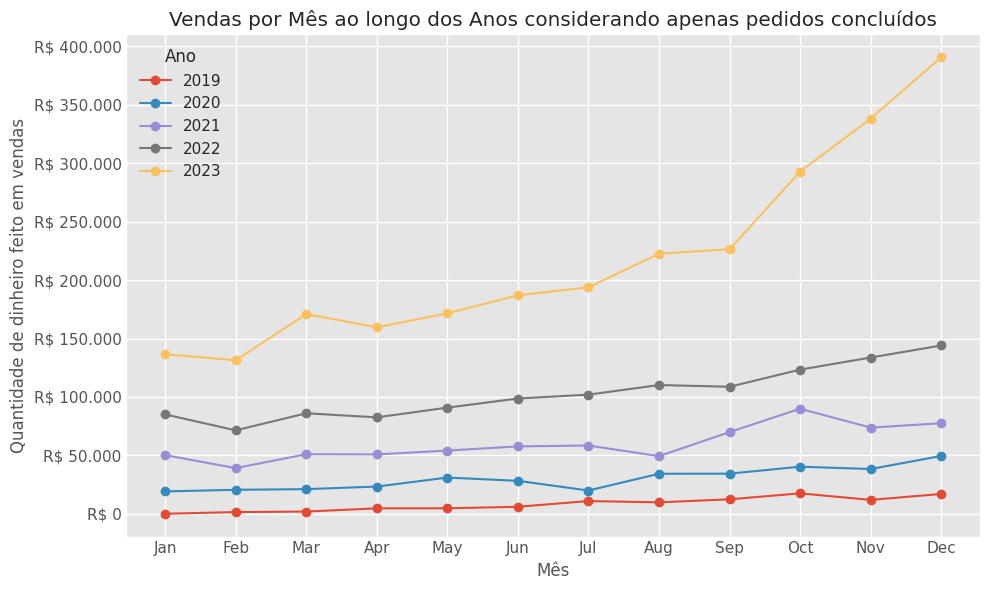

In [145]:
query2 = client.query(
    """
    SELECT EXTRACT(MONTH FROM o.created_at) AS month,
       EXTRACT(YEAR FROM o.created_at) AS year,
       SUM(oi.sale_price*o.num_of_item) AS total_sales
    FROM `bigquery-public-data.thelook_ecommerce.orders` AS o
    JOIN `bigquery-public-data.thelook_ecommerce.order_items` AS oi ON o.order_id = oi.order_id
    WHERE o.status = "Complete"  -- Considerando apenas os pedidos com status "Complete"
    GROUP BY year, month
    ORDER BY year, month
    """)

#colocando em um dataframe do pandas
df2 = query2.to_dataframe()

# Agrupa os dados por ano e mês, somando as vendas
pivot_df2 = df2.pivot(index='month', columns='year', values='total_sales')

# Cria o gráfico de linha para cada ano
plt.figure(figsize=(10, 6))
for year in pivot_df2.columns:
    plt.plot(pivot_df2.index, pivot_df2[year], marker='o', label=str(year))

# Configurações do gráfico
plt.xlabel('Mês')
plt.ylabel('Quantidade de dinheiro feito em vendas')
plt.title('Vendas por Mês ao longo dos Anos considerando apenas pedidos concluídos')
plt.legend(title='Ano')

# Ajusta os rótulos do eixo x para exibir os nomes dos meses
plt.xticks(ticks=range(1, 13), labels=order_months)  # Defina os rótulos de 1 a 12 com os nomes dos meses

#formatando campo de moeda
formatter = ticker.FuncFormatter(format_currency)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


### Pesquisando quais marcas mais venderam até o momento

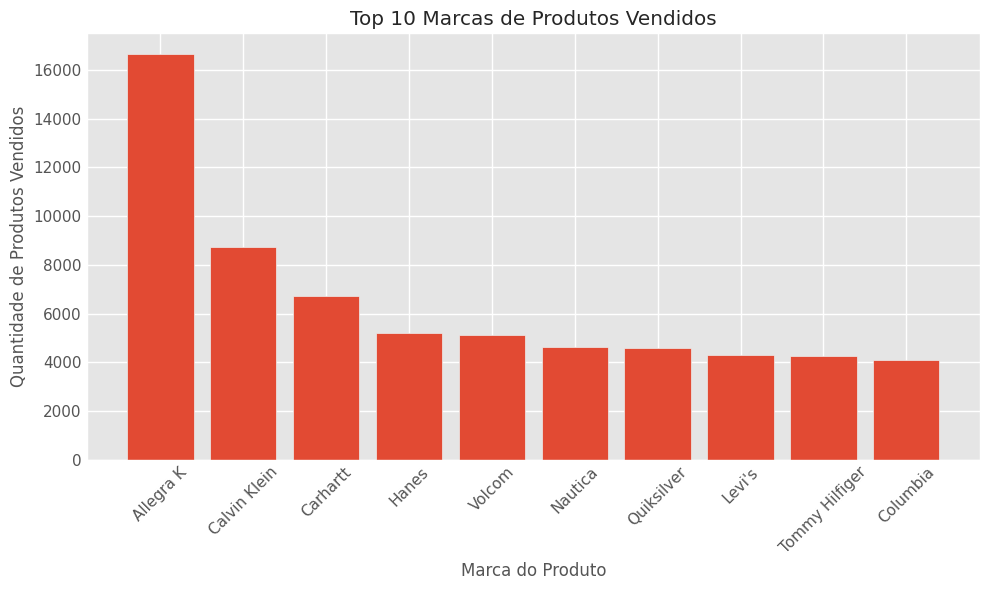

In [135]:
query4 = client.query(
    """
    SELECT ii.product_brand, COUNT(*) as brand_count
    FROM `bigquery-public-data.thelook_ecommerce.inventory_items` ii LEFT JOIN
    `bigquery-public-data.thelook_ecommerce.order_items` oi on ii.id = oi.inventory_item_id LEFT JOIN `bigquery-public-data.thelook_ecommerce.orders` ord on oi.order_id = ord.order_id
    GROUP BY ii.product_brand
    ORDER BY brand_count DESC
    LIMIT 10;
    """)

#colocando em um dataframe do pandas
df4 = query4.to_dataframe()

# Configurações do gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df4['product_brand'], df4['brand_count'])
plt.xlabel('Marca do Produto')
plt.ylabel('Quantidade de Produtos Vendidos')
plt.title('Top 10 Marcas de Produtos Vendidos')
plt.xticks(rotation=45)  # Rotaciona os rótulos para melhor legibilidade

plt.tight_layout()
plt.show()


### Consulta para ver o número de venda de cada mês



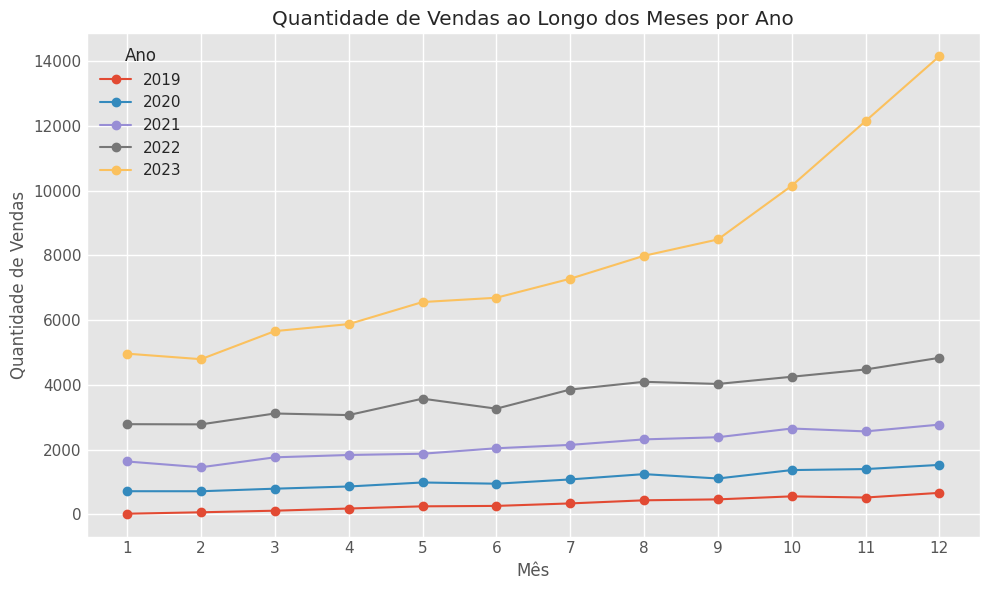

In [143]:
query5 = client.query(
    """
    SELECT EXTRACT(MONTH FROM o.created_at) AS month,
     EXTRACT(YEAR FROM o.created_at) AS year,
     count(oi.order_id) AS total_sales_number
     FROM `bigquery-public-data.thelook_ecommerce.orders` AS o
     JOIN `bigquery-public-data.thelook_ecommerce.order_items` AS oi ON o.order_id = oi.order_id
     GROUP BY year, month
     ORDER BY year, month
    """)

#colocando em um dataframe do pandas
df5 = query5.to_dataframe()

# Ordena o DataFrame pelo ano e mês para garantir a ordem correta no gráfico
df5 = df5.sort_values(['year', 'month'])

# Plotagem do gráfico de linha para cada ano
plt.figure(figsize=(10, 6))
years = df5['year'].unique()
for year in years:
    data = df5[df5['year'] == year]
    plt.plot(data['month'], data['total_sales_number'], marker='o', label=str(year))

# Configurações do gráfico
plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses por Ano')
plt.legend(title='Ano')
plt.xticks(range(1, 13))  # Define os rótulos do eixo x para representar os meses de 1 a 12

plt.tight_layout()
plt.show()

### Receita Total por Categoria de Produto
Qual produto está gerando mais receita?

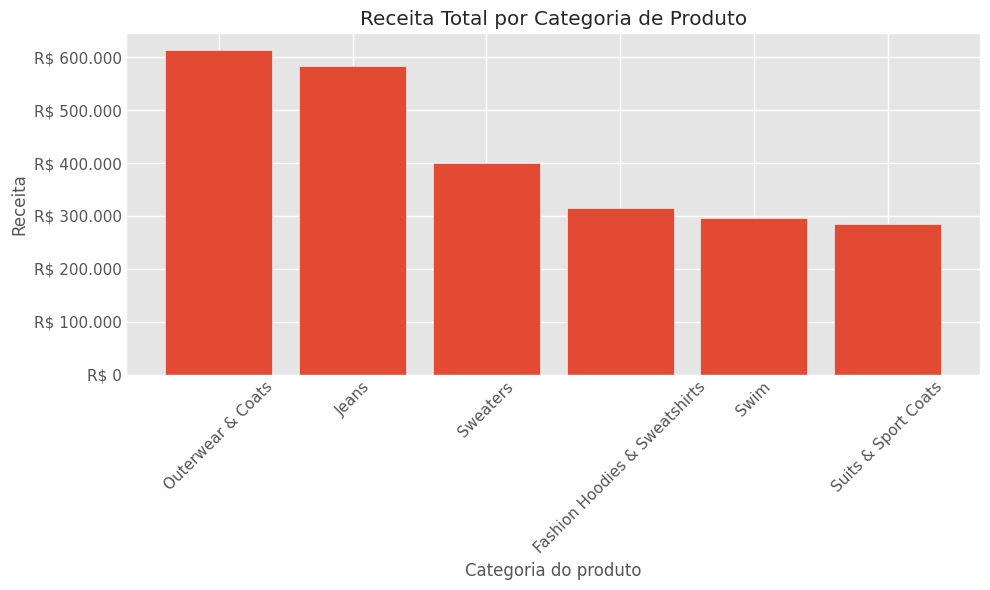

In [151]:
query6 = client.query(
    """
    SELECT
      pr.category AS product_category,
      SUM(oi.sale_price * o.num_of_item) AS total_revenue
    FROM
      `bigquery-public-data.thelook_ecommerce.order_items` AS oi
    JOIN
      `bigquery-public-data.thelook_ecommerce.products` AS pr
    ON
      oi.product_id = pr.id
    JOIN
      `bigquery-public-data.thelook_ecommerce.orders` AS o
    ON
      oi.order_id = o.order_id
    WHERE
      o.status = 'Complete'
    GROUP BY
      pr.category
    ORDER BY
      total_revenue DESC
    LIMIT 6;
    """)

#colocando em um dataframe do pandas
df6 = query6.to_dataframe()

# Configurações do gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df6['product_category'], df6['total_revenue'])
plt.xlabel('Categoria do produto')
plt.ylabel('Receita')
plt.title('Receita Total por Categoria de Produto')
plt.xticks(rotation=45)  # Rotaciona os rótulos para melhor legibilidade

#formatando campo de moeda
formatter = ticker.FuncFormatter(format_currency)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()